# Minimal example using the database and DPsim

## Load credentials and sensitive data

In [1]:
import json
# Opening JSON file
with open('../credentials/credentials.json', 'r') as openfile:
    # Reading from json file
    credentials = json.load(openfile)

## Configure the connection to the database and set the collections

In [2]:
import pymongo
import sys
from pymongo import MongoClient
import pandas as pd

In [3]:
db = MongoClient(credentials['pymongo_url'], 
                    credentials['pymongo_port'], 
                     username=credentials['pymongo_username'],
                     password=credentials['pymongo_password']).get_database(credentials['pymongo_database_name'])

In [4]:
current_collection = eval(credentials['meter_current_name'])
power_collection = eval(credentials['meter_power_name'])
voltage_collection = eval(credentials['meter_voltage_name'])

## Import dependencies for Simulation

In [5]:
import pandas as pd
import numpy as np
import os
import sys
import dpsimpy
from dpsim import matpower
import datetime

## Read the circuit file

In [6]:
# List of assets
meters_assets_dict={'W0':[], 'W1':[], 'W2':[], 'W3': ['load2'], 'W4': ['load3'], 'W5':['load4'], 'W6': ['load4']}

In [7]:
# Reader(mpc_file_path): mpc_file_path is relative to the Notebook dir
mpc_reader = matpower.Reader('../network_model/load_flow_pilot_district_mpc_struct_insp.mat', 'mpc')
system = mpc_reader.load_mpc()

/opt/conda/lib/python3.10/site-packages/dpsim/matpower.py:639: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.dpsimpy_comp_dict[extnet_name][0].set_parameters(extnet_v)


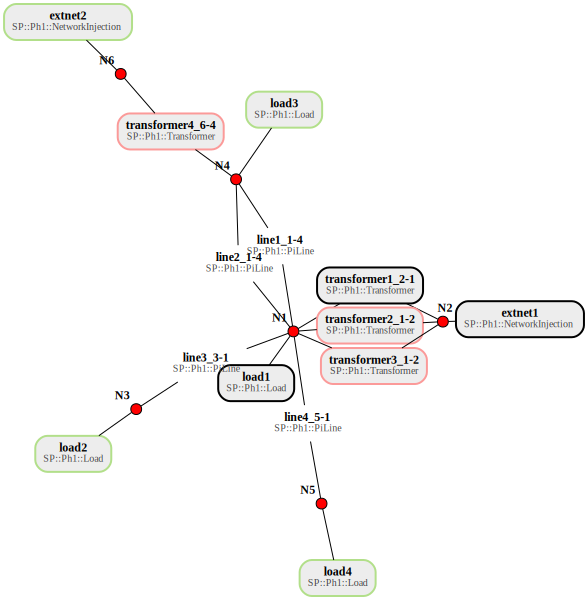

In [8]:
# Plot DPsim model
system

# Query to select dates to calculate the circuit results

In [9]:
import ipywidgets as widgets
from ipywidgets import Layout, Box, Dropdown, Label


# available dates in collection:
power_collection_dates=sorted(power_collection.distinct("date"), key=lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
power_collection_meters=sorted(power_collection.distinct("id"))

start_date_selection= widgets.Select(
                                        options= power_collection_dates,
                                        value='2021-10-25',
                                        # rows=10,
                                        description='start date:',
                                        disabled=False
                                    )

display(start_date_selection)

end_date_selection= widgets.Select(
                                        options= power_collection_dates,
                                        value='2021-10-31',
                                        # rows=10,
                                        description='end date:',
                                        disabled=False
                                    )

display(end_date_selection)

Select(description='start date:', index=81, options=('2021-08-05', '2021-08-06', '2021-08-07', '2021-08-08', '…

Select(description='end date:', index=87, options=('2021-08-05', '2021-08-06', '2021-08-07', '2021-08-08', '20…

## Get data for the selected timeframe

In [10]:
user_requested_timestamps= pd.date_range(start_date_selection.value, end_date_selection.value, freq='5Min').tolist()
user_query = { "date": { "$gte": start_date_selection.value , "$lte": end_date_selection.value}}
user_query_power_df = pd.DataFrame(power_collection.find(user_query))
user_query_power_df

,_id,,date,00:00:00,00:05:00,00:10:00,00:15:00,00:20:00,00:25:00,00:30:00,...,23:20:00,23:25:00,23:30:00,23:35:00,23:40:00,23:45:00,23:50:00,23:55:00,id,power_type
0,6322fda1ce520b1fd2dc78ac,0,2021-10-26,41.547665,42.438880,41.258075,41.252773,41.965179,41.858038,41.559484,...,42.019979,41.830807,45.402264,51.917066,50.089197,48.985303,47.610372,46.150158,W4,apparent
1,6322fda1ce520b1fd2dc78ad,1,2021-10-26,40.171788,41.015590,39.796011,39.888964,40.603351,40.345284,39.932533,...,40.598639,40.481615,44.125054,51.308705,49.083353,47.865591,46.344943,44.947521,W4,positive_active
2,6322fda1ce520b1fd2dc78ae,2,2021-10-26,-8.754117,-8.927412,-9.062231,-8.632040,-8.606026,-9.382531,-9.661526,...,-9.395557,-8.977946,-8.778704,-5.516881,-7.955475,-8.551503,-9.244671,-8.846024,W4,positive_reactive
3,6322fed5ce520b1fd2dc78cd,0,2021-10-30,46.336499,50.084744,46.573778,44.946850,51.556749,48.142561,45.643011,...,40.045276,40.076982,39.747999,47.355186,52.160294,51.305784,48.664094,48.030849,W4,apparent
4,6322fed5ce520b1fd2dc78ce,1,2021-10-30,45.144727,49.224550,45.498884,43.630560,50.780907,47.163726,44.425855,...,38.728230,38.606091,38.165545,46.657992,51.640495,50.755338,47.909220,46.974602,W4,positive_active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,63247a39ce520b1fd2dc9dc2,1,2021-10-29,0.042585,0.042765,0.042767,0.042893,0.042899,0.042827,0.042815,...,0.042538,0.042682,0.042537,0.042611,0.042831,0.042819,0.042929,0.042778,W6,positive_active
101,63247a39ce520b1fd2dc9dc3,2,2021-10-29,-0.047634,-0.047956,-0.048407,-0.048451,-0.048660,-0.048437,-0.048253,...,-0.048380,-0.048378,-0.048373,-0.048438,-0.048461,-0.048438,-0.048619,-0.048407,W6,positive_reactive
102,63247b2ace520b1fd2dc9ddc,0,2021-10-26,0.584763,0.588841,0.586150,0.585529,0.587172,0.583962,0.588329,...,0.587919,0.588853,0.586259,0.589545,0.589138,0.588579,0.589652,0.588322,W6,apparent
103,63247b2ace520b1fd2dc9ddd,1,2021-10-26,0.042859,0.043286,0.042874,0.042770,0.042870,0.042678,0.042771,...,0.042906,0.042659,0.042689,0.042721,0.042815,0.042461,0.042668,0.042545,W6,positive_active


## Process the retrieved data

In [11]:
db_columns=list(user_query_power_df.columns.values)
time_format = "%H:%M:%S"
db_times=[]
db_colums_withoutTime=[]
for col in db_columns:
    try:
        db_times.append(datetime.datetime.strptime(col, time_format).time())
        # print(f"{col} is the correct date string format.")
    except ValueError:
        db_colums_withoutTime.append(col)
        # print(f"{i} is the incorrect date string format.")

header=[times.strftime("%H:%M:%S") for times in db_times]
# header.insert(0,'date')

melted_df=pd.melt(user_query_power_df, id_vars=['date', 'id', 'power_type'], value_vars=header, var_name='time', value_name='power')
# user_query_power_df[user_query_power_df['power_type']=='positive_active'][header]
pivoted_df=pd.pivot_table(melted_df, values='power', columns='power_type', index=['date', 'time', 'id'])\
            .reset_index()
pivoted_df.columns.name=None
pivoted_df.insert(loc=0, column='datetime', value=pd.to_datetime(pivoted_df['date'] + ' ' + pivoted_df['time'], format="%Y-%m-%d %H:%M:%S"))
processed_power_df=pivoted_df.dropna()
processed_power_df

,datetime,date,time,id,apparent,positive_active,positive_reactive
0,2021-10-25 00:00:00,2021-10-25,00:00:00,W2,1.542820,0.863157,-1.130695
1,2021-10-25 00:00:00,2021-10-25,00:00:00,W3,4.167453,0.885610,4.037296
2,2021-10-25 00:00:00,2021-10-25,00:00:00,W4,39.954579,38.189706,-10.104962
3,2021-10-25 00:00:00,2021-10-25,00:00:00,W5,0.934930,0.020153,-0.918053
4,2021-10-25 00:00:00,2021-10-25,00:00:00,W6,0.584307,0.042963,-0.048518
...,...,...,...,...,...,...,...
10075,2021-10-31 23:55:00,2021-10-31,23:55:00,W2,1.534457,0.860742,-1.132833
10076,2021-10-31 23:55:00,2021-10-31,23:55:00,W3,4.136900,0.910842,4.000568
10077,2021-10-31 23:55:00,2021-10-31,23:55:00,W4,47.332395,46.345882,-8.114340
10078,2021-10-31 23:55:00,2021-10-31,23:55:00,W5,0.932285,0.019906,-0.917448


# Simulation service

## Set-up and start simulation with DPsim

In [12]:
sim_name = 'pilot_uc6_insp'
dpsimpy.Logger.set_log_dir('logs/' + sim_name)
logger = dpsimpy.Logger(sim_name)

for node in system.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
    logger.log_attribute(node.name()+'.S', 's', node)

# Parametrize and run simulation
sim = dpsimpy.Simulation(sim_name, dpsimpy.LogLevel.info)
sim.set_system(system)
sim.set_time_step(1)
sim.set_final_time(len(user_requested_timestamps))
sim.set_domain(dpsimpy.Domain.SP)
sim.set_solver(dpsimpy.Solver.NRP)
sim.do_init_from_nodes_and_terminals(False)
sim.add_logger(logger)
sim.start()

[19:51:55.856078 pilot_uc6_insp info] Initialize simulation: pilot_uc6_insp
[19:51:55.856173 pilot_uc6_insp_PF_Solver warning] No suitable quantity found for setting mBaseApparentPower. Using 100000000.0 VA.
[19:51:55.856367 pilot_uc6_insp_PF_Solver warning] Unable to get base voltage at N1
[19:51:55.856376 pilot_uc6_insp_PF_Solver warning] Unable to get base voltage at N3
[19:51:55.856380 pilot_uc6_insp_PF_Solver warning] Unable to get base voltage at N4
[19:51:55.856383 pilot_uc6_insp_PF_Solver warning] Unable to get base voltage at N5
[19:51:55.856532 pilot_uc6_insp info] Scheduling tasks.
[19:51:55.856621 pilot_uc6_insp info] Scheduling done.
[19:51:55.856623 pilot_uc6_insp info] Opening interfaces.
[19:51:55.856625 pilot_uc6_insp info] Start synchronization with remotes on interfaces
[19:51:55.856626 pilot_uc6_insp info] Synchronized simulation start with remotes
[19:51:55.856627 pilot_uc6_insp info] Start simulation: pilot_uc6_insp
[19:51:55.856629 pilot_uc6_insp info] Time step:

In [13]:
for component in system.components:
    print( component.name() )

load1
extnet1
load2
load3
load4
extnet2
transformer1_2-1
line1_1-4
line2_1-4
transformer2_1-2
transformer3_1-2
line3_3-1
line4_5-1
transformer4_6-4


## Helper functions to assign mesurements from the database to the simulator

In [14]:
def get_meter_values(timestamp, meter):
    try:
        P= processed_power_df[(processed_power_df['id']==meter) & (processed_power_df['datetime']==timestamp)].iloc[0]['positive_active']
        Q= processed_power_df[(processed_power_df['id']==meter) & (processed_power_df['datetime']==timestamp)].iloc[0]['positive_reactive']
        return [P,Q]
    except:
        #print('[', timestamp, ']', '[', meter, ']', 'Warn: no available measurement dropping simulation step')
        raise ValueError("There is no available measurement in this timestep")
        #return ['nan', 'nan']

In [15]:
kw_w= 1e3
def pq_assign_dpsim(timestamp):
    """
    take pq values of measurements and set the values in the DPSim to the corresponding asset
    """
    for k, v in meters_assets_dict.items():
        meter= k
        assets= v
        
        for asset in v:
            P_set=0
            Q_set =0
            [P_meter,Q_meter]=get_meter_values(timestamp, meter)

            P_set = P_set + (P_meter/3) # check if power is single or three phase, if RMS or absolute value etc.?
            Q_set = Q_set + (Q_meter/3)
        
            #print('[', timestamp, ']', '[', meter, ']', '[', asset, ']', 'Info: assigning [P,Q] values', P_set, Q_set)

            sim.get_idobj_attr(asset, 'P').set(P_set*kw_w)
            sim.get_idobj_attr(asset, 'Q').set(Q_set*kw_w)

## Main simulation loop

In [16]:
sim_timesteps=[]
for dttm in user_requested_timestamps:
        try:
            pq_assign_dpsim(dttm)
            sim_timesteps.append(dttm.to_pydatetime())
            #print (dttm.to_pydatetime())
        except ValueError:
            pass
            #print('[',dttm,'] Current timestep was ignored due to one or more measurements missing')
        sim.next()
sim.stop()



[19:52:06.479516 pilot_uc6_insp info] Simulation calculation time: 10.622882
[19:52:06.479552 pilot_uc6_insp info] Simulation finished.


# Results

## Load file with the results

In [17]:
from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *

path = './logs/pilot_uc6_insp/'
logName = 'pilot_uc6_insp';
dataType = '.csv';
logFilename = path + logName + dataType;
ts_dpsim = read_timeseries_dpsim(logFilename)

column number: 12
results length: 1729
real column names: []
complex column names: ['N1.S', 'N1.V', 'N2.S', 'N2.V', 'N3.S', 'N3.V', 'N4.S', 'N4.V', 'N5.S', 'N5.V', 'N6.S', 'N6.V']


## Enable the selection of the results for the nodes

In [18]:
list_results_opt=list(ts_dpsim.keys())
result_selection= widgets.Select(
                                        options= list_results_opt,
                                        value= list_results_opt[7],
                                        # rows=10,
                                        description='result to show:',
                                        disabled=False
                                    )

display(result_selection)



Select(description='result to show:', index=7, options=('N1.S', 'N1.V', 'N2.S', 'N2.V', 'N3.S', 'N3.V', 'N4.S'…

## Plot the selected result

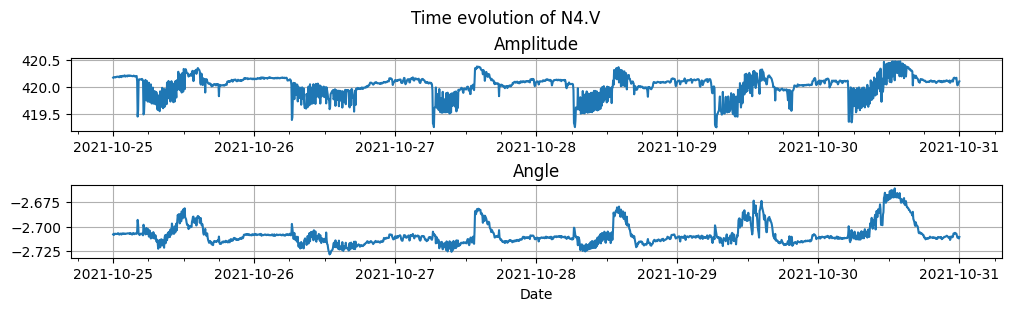

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#%matplotlib widget
X=sim_timesteps

result_selection.value
fig, axs = plt.subplots(2, 1, figsize=(10, 3), layout='constrained')

fig.suptitle("Time evolution of " + result_selection.value)


Y=ts_dpsim[result_selection.value].abs().values
axs[0].plot(X,Y)
axs[0].set_title('Amplitude')
axs[0].grid(True)
#axs[0].set_ylim(411,412)


Y=ts_dpsim[result_selection.value].phase().values
axs[1].plot(X,Y)
axs[1].grid(True)
axs[1].set_title('Angle')


axs[1].set_xlabel('Date')
axs[0].xaxis.set_major_locator(mdates.DayLocator())
axs[0].xaxis.set_minor_locator(mdates.HourLocator(byhour=(0,6,12,18,)))
axs[1].xaxis.set_major_locator(mdates.DayLocator())
axs[1].xaxis.set_minor_locator(mdates.HourLocator(byhour=(0,6,12,18,)))
plt.grid(True)


plt.show()

